# Linear Regression

In [0]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 1e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q,R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    n, p = X.shape
    return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 2000
n = 10000
N = 200
b = 50
n_max_iter = 2000
epsilon = 0.05
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

# ======= Solving problem =======

steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}'.format(experiment))
    theta_0 = np.random.randn(p)
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = solve_local_problem(Qs[i], Rs[i], theta, ys[i], h*N, n)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)
        

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        

        # SGD
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = make_SGD_step(Xs[i], theta, ys[i], h)
            if relative_error(theta) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
        end_time = time.time()
        times_sgd.append(end_time-start_time)   
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 10
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))

    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

In [0]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, label = 'Splitting')
plt.loglog(hs, steps_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, label = 'Splitting')
plt.loglog(hs, times_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

plt.savefig('sgd_split_step_t{}.svg'.format(epsilon))
plt.show()

# Logistic regression

In [0]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

# ======= Function definitions =======

def sigmoid(x):
    return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    z_0 = Q.T@theta_0
    def rhs(z, t):
        lin_hyp = R.T @ z
        return -1/n * R@(sigmoid(lin_hyp) - y)
    z_h = odeint(rhs, z_0, h_seq)[-1]

    theta = Q@(z_h - z_0) + theta_0
    return theta

def loss_logreg(X, theta, y):
    h_theta = [1/(1+np.exp(-theta.T @ x)) for x in X]
    y_true = y
    y_pred = h_theta
    return log_loss(y_true, y_pred)

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

# ======= Problem generation =======

p = 784
n = 12665
b = 32
N = n//b
n_max_iter = 3000
n_experiments = 30

epsilon = 0.3
hs = np.logspace(-3, 3.5, 12)

X, y = generate_problem_logistic_regression()
print('Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss()
print('Model loaded')

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')
# ======= Solving problem =======
steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}'.format(experiment))
    theta_0 = np.random.randn(p)
    model = LogisticRegression()
    criterion = nn.BCELoss()
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        losss_spl = []
        losss_sgd = []
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_spl) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = Xs[i]
            y_batch = ys[i]
            loss = loss_logreg(X_batch, theta, y_batch)
            losss_spl.append(loss)

            theta = make_splitting_step(Qs[i], Rs[i], theta, y_batch, h*N, n)
            theta = np.squeeze(theta)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_spl)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        
        # SGD
        theta = copy.deepcopy(theta_0)
        model.train()
        for parameter in model.parameters():
            parameter.data[0] = torch.from_numpy(theta)
            break
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_sgd) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = torch.from_numpy(Xs[i]).float()
            y_batch = torch.from_numpy(ys[i]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            # Compute Loss
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            losss_sgd.append(loss.data)
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - h*parameter.grad.data
            if loss_moving_average(losss_sgd) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
            # print(loss_moving_average(losss_sgd))
        end_time = time.time()
        times_sgd.append(end_time-start_time)
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 1  
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_sgd)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))
    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [00:10<00:00, 383031.01it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 85024.23it/s]
32768it [00:00, 56346.05it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



 98%|█████████▊| 1622016/1648877 [00:06<00:00, 309862.46it/s]
1654784it [00:06, 259699.75it/s]                             
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 21160.43it/s]            

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
Data loaded
Model loaded
QR finished
💩 Experiment 0


NameError: ignored

12665


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


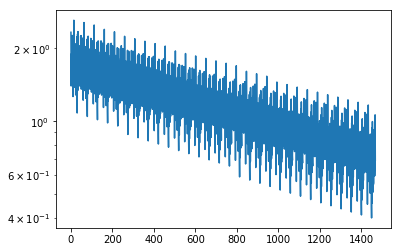

In [0]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, label = 'Splitting')
plt.loglog(hs, steps_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

plt.savefig('sgd_split_logreg_times{}.svg'.format(epsilon))
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, label = 'Splitting')
plt.loglog(hs, times_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

plt.savefig('sgd_split_logreg_t{}.svg'.format(epsilon))
plt.show()

# Softmax regression

In [0]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# ======= Function definitions =======
## ======= SPLITTING =======
def softmax(x):
	normalization = np.sum(np.exp(x))
	return np.array([np.exp(x_i)/normalization for x_i in x])

def sigmoid(X_batch, thetas):
    if len(X_batch.shape) > 1:
        batch_size, p = X_batch.shape
    else:
        X_batch = np.expand_dims(X_batch, axis=0)
        batch_size, p = X_batch.shape
    K = len(thetas) - 1
    h = np.zeros((batch_size, K))
    theta_b = thetas[-1]
    for i_object in range(batch_size):
        x = X_batch[i_object]
        etas = [np.float(thetas[k] @ x + theta_b[k]) for k in range(K)]
        normalization = np.sum(np.exp(etas))
        h[i_object, :] = np.exp(etas)/normalization
    return h

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    z_0 = Q.T@theta_0
    def rhs(z, t):
        lin_hyp = R.T @ z
        return -1/n * R@(sigmoid(lin_hyp) - y)
    z_h = odeint(rhs, z_0, h_seq)[-1]

    theta = Q@(z_h - z_0) + theta_0
    return theta

def make_splitting_step(thetas_0, Q, R, X_batch, y_batch, n, h):
	Q, R = copy.deepcopy(Q), copy.deepcopy(R)
	batch_size 		= len(y_batch)
	y_batch_one_hot = np.zeros((batch_size, K))
	y_batch_one_hot[np.arange(batch_size), y_batch] = 1
	thetas_final = []
	h_seq = [0, h]
	K = len(thetas_0) - 1

	# Biases update (Need to verify 🤔)
	theta_b_0 = thetas_0[-1]
	batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
	theta_b_final = theta_b_0 + h*1/n*(np.sum(batch_softmax_matrix, axis = 0) - np.sum(y_batch_one_hot, axis=0))

	# Weights update
	etas_0 			= R @ Q @ thetas_0[:K].T # batch_size x K
	for i_class in range(K):
		theta_class_0 	= thetas_0[i_class]
		eta_class_0 	= etas_0[:, i_class]
		labels_k 		= y_batch_one_hot[:, i_class]
		def rhs(eta_0, t, etas_0, labels_class, i_class, R, n):
			
			etas_0[:, i_class] = eta_0
			batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
			softmax_class = batch_softmax_matrix[:, i_class]
			return -1/n * R@(softmax_class - labels_class)
		eta_class_h = odeint(rhs, eta_class_0, h_seq, args=(etas_0, labels_k, i_class, R, n))[-1]

		theta_class_final = Q@(eta_class_h - eta_class_0) + theta_class_0
		thetas_final.append(theta_class_final)
  
	thetas_final.append(theta_b_final)
	return thetas_final

def train_splitting(model, Qs, Rs, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	model     = model.to(device)
	criterion = nn.CrossEntropyLoss()
	N_batches  = int(Rs.size(0))
	batch_size = int(Rs.size(1))
	K = torch.argmax(y_trains) + 1
	p = X_test.size(1)
	n = N_batches*batch_size
	thetas = []
	parameter_list = []
	for parameter in model.parameters():
		parameter_list.append(parameter.data.cpu().numpy())
	thetas = [parameter_list[0][i_class] for i_class in range(K)]
	thetas.append(parameter_list[1])

	history = {}  
	history['train_loss'] = np.zeros(n_epochs)
	history['test_loss']  = np.zeros(n_epochs)
	history['train_acc']  = np.zeros(n_epochs)
	history['test_acc']   = np.zeros(n_epochs)

	for epoch in tqdm(range(n_epochs)):
		#==== Forward steps  ====
		model.train()
		h = hs[epoch]
		for i_batch in tqdm(range(N_batches)):
			# Forward pass
			images_q, images_r, labels 	= Qs[i_batch], Rs[i_batch], y_trains[i_batch]
			images_q, images_r, labels 	= images_q.to(device), images_r.to(device), labels.to(device)
			outputs 					= model(X_trains[i_batch]) 

			# Splitting step
			model.zero_grad()
			thetas = make_splitting_step(thetas, images_q, images_r, labels, outputs, n, h)         

		# Metrics calculation
		parameter_list = [thetas[:int(K)], thetas[-1]]
		model = model_init(model, parameter_list).float()
		predictions = model(images)
		loss = criterion(predictions, labels)
		history['train_loss'][epoch] = loss.data
		pred_label = torch.max(predictions, 1, keepdim=True)[1]
		history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
		with torch.no_grad():
			model.eval()
			Xst = X_test.to(device)
			yst = y_test.to(device)
			predictions = model(Xst)
			loss = criterion(predictions, yst)
			history['test_loss'][epoch] = loss.data
			pred_label = torch.max(predictions, 1, keepdim=True)[1]
			history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
	return history

## ======= SGD =======

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
    	x = x.contiguous().view(x.size(0), -1)
    	out = F.softmax(self.linear(x), dim=1)
    	return out

def load_model(X_test, y_test):
	'''
	Returns logistic regression model
	Which is just single linear layer with flattening at the beginning and softmax at the end
	'''
	input_dim = X_test[0].numel()

	# Handling with usual and one-hot format
	if any(y_test > 1):
		output_dim = max(y_test) + 1
	else:
		output_dim = 2

	model = LogisticRegression(input_dim, output_dim)
	return model

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False):
	'''
	Load batches of MNIST data.

	Output: X_trains - N_train batches of training data, 
			y_trains - N_train batches of labels,
			X_test - test points
			y_test - test labels
	X_trains: torch.array of shape (N_train,batch_size,*X_train[0].shape),
		where 
		N_train - the number of batches, 
		batch_size - batch size
		*X_train[0].shape - shape of the dataset point;

	y_trains: torch.array of shape (N_train,batch_size);

	X_test: torch.array of shape (s_test,*X_train[0].shape),
		where
		s_test - the number of test points;

	y_test: torch.array of shape (s_test);
	'''
	number_of_classes = 3
	trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
	X_train = trainset.data.to(dtype=torch.float)/255
	y_train = trainset.targets
	mask    = y_train <= number_of_classes
	X_train = X_train[mask]
	y_train = y_train[mask]
	X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
	y_train.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_train))
		X_train = X_train[shuffling]
		y_train = y_train[shuffling]

	# Download and load the test data
	testset = datasets.MNIST('./mnist_data/', download=True, train=False)
	X_test = testset.data.to(dtype=torch.float)/255
	y_test = testset.targets
	mask   = y_test <= number_of_classes
	X_test = X_test[mask]
	y_test = y_test[mask]
	X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
	y_test.view(-1).long()

	if shuffle == True:
		shuffling = torch.randperm(len(y_test))
		X_test = X_test[shuffling].to(device)
		y_test = y_test[shuffling]

	s_train = len(y_train)
	s_test  = len(y_test)

	N_train = int(s_train/batch_size)   # Number of training batches

	X_trains    = torch.zeros((N_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
	y_trains    = torch.zeros((N_train, batch_size), requires_grad=False, dtype=torch.int64).to(device)
	if qr_mode:
		Qs      = torch.zeros((N_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
		Rs      = torch.zeros((N_train, batch_size, batch_size), requires_grad=False).to(device)
		print('🤖QR started')

	for i in range(N_train):
		X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
		y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
		if qr_mode:
			Qs[i], Rs[i] = torch.qr(X_trains[i].T)		

	if qr_mode:
		print('✅QR computed')
		return X_trains, y_trains, X_test, y_test, Qs, Rs
	else:
		return X_trains, y_trains, X_test, y_test

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	model     = model.to(device)
	criterion = nn.CrossEntropyLoss()
	N_batches  = int(X_trains.size(0))
	batch_size = int(X_trains.size(1)) 

	history = {}  
	history['train_loss'] = np.zeros(n_epochs)
	history['test_loss']  = np.zeros(n_epochs)
	history['train_acc']  = np.zeros(n_epochs)
	history['test_acc']   = np.zeros(n_epochs)

	for epoch in tqdm(range(n_epochs)):
		#==== Forward steps  ====
		model.train()
		h = hs[epoch]
		for i_batch in range(N_batches):
			# Forward pass
			images, labels = X_trains[i_batch], y_trains[i_batch]
			images, labels = images.to(device), labels.to(device)
			predictions = model(images)
			loss = criterion(predictions, labels)

			# Gradient step
			model.zero_grad()
			loss.backward()
			for idp, parameter in enumerate(model.parameters()):
				grad           = parameter.grad.data
				grad           = grad.to(device)
				parameter.data = parameter.data - h*grad

		# Metrics calculation
		history['train_loss'][epoch] = loss.data
		pred_label = torch.max(predictions, 1, keepdim=True)[1]
		history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
		with torch.no_grad():
			model.eval()
			Xst = X_test.to(device)
			yst = y_test.to(device)
			predictions = model(Xst)
			loss = criterion(predictions, yst)
			history['test_loss'][epoch] = loss.data
			pred_label = torch.max(predictions, 1, keepdim=True)[1]
			history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
	return history

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

def model_init(model, parameter_list):
	new_model = copy.deepcopy(model)
	for idp, parameter in enumerate(new_model.parameters()):
		parameter.data = torch.tensor(parameter_list[idp]).to(device)
	return new_model

def plot_histories(histories, titles, suptitle=''):
	fig = plt.figure(figsize = (16,9))
	fig.suptitle(suptitle)
	plt.subplot(2, 2, 1)
	plt.xlabel('epoch')
	plt.ylabel('Train loss')
	for history, title in zip(histories, titles):
		plt.semilogy(history['train_loss'], label = title)
	plt.legend()

	plt.subplot(2, 2, 2)
	plt.xlabel('epoch')
	plt.ylabel('Train accuracy')
	for history, title in zip(histories, titles):
		plt.plot(history['train_acc'], label = title)
	plt.legend()
 
	plt.subplot(2, 2, 3)
	plt.xlabel('epoch')
	plt.ylabel('Test loss')
	for history, title in zip(histories, titles):
		plt.semilogy(history['test_loss'], label = title)
	plt.legend()
 
	plt.subplot(2, 2, 4)
	plt.xlabel('epoch')
	plt.ylabel('Test accuracy')
	for history, title in zip(histories, titles):
		plt.plot(history['test_acc'], label = title)
	plt.legend()
 
	plt.savefig('history {}.pdf'.format(suptitle))
	plt.show()

# ======= Problem generation =======

batch_size = 32
X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=batch_size, qr_mode = True)
print('🐱Data loaded')

N_batches = int(len(y_trains)/batch_size)
n_epochs = 5
h = 0.001
hs = [h*N_batches for i in range(n_epochs)]
model = load_model(X_test, y_test)
print('🐱Model loaded')

parameter_list_init = []
for parameter in model.parameters():
    parameter_list_init.append(parameter)

# ======= Solving problem =======
model = model_init(model, parameter_list_init)
print('🐱Model Initialized')

# print('🤖SGD started')
# history_sgd = train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs)
# print('✅SGD finished')

# model = model_init(model, parameter_list_init)
# print('🐱Model Initialized')

print('🤖Splitting started')
history_spl = train_splitting(model, Qs, Rs, y_trains, X_test, y_test, n_epochs, hs, weights_name = './')
print('✅Splitting finished')

🤖QR started
✅QR computed
🐱Data loaded
🐱Model loaded
🐱Model Initialized
🤖Splitting started


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: ignored

In [0]:
plot_histories([history_sgd, history_spl], ['SGD','Splitting'], 'Softmax regression on MNIST, 3 classes')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


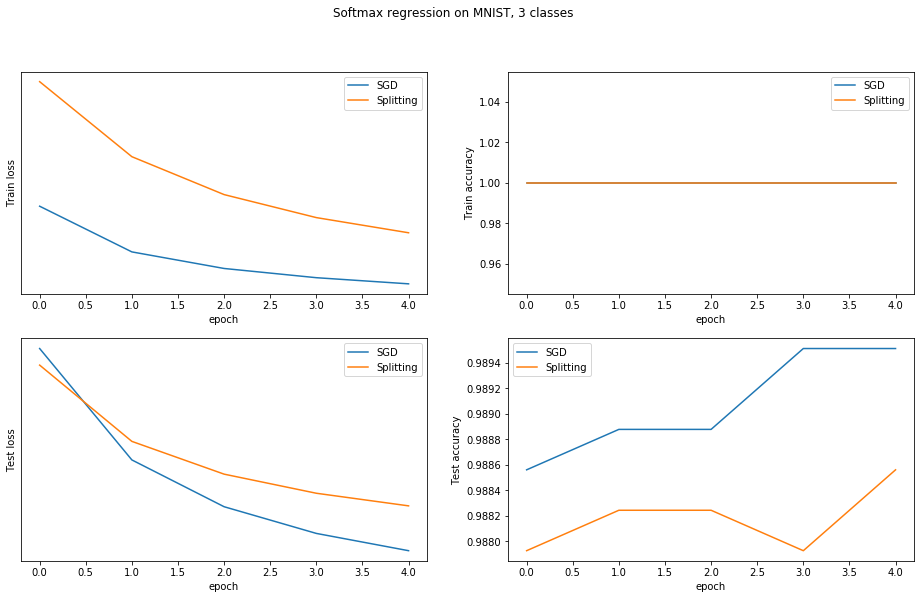

In [0]:
plot_histories([history_sgd, history], ['SGD','Splitting'], 'Softmax regression on MNIST, 3 classes')

In [0]:
# TRASH

		

    etas_0 = [Q.T @ thetas_0[i] for i in range(K)]
	etas
    def rhs(etas, t, X_batch, y_batch, thetas, r, n):
        batch_size = len(y_batch)
        y_batch_one_hot = np.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), y_batch] = 1
        etas    = np.array(etas)
        vector  = np.exp(etas*r)
        normalization = np.sum(vector)
        return np.squeeze(-1/n * r * (sigmoid(X_batch, thetas) - y_batch_one_hot))

    eta = odeint(rhs, etas_0, h_seq, args=(X_batch, y_batch, thetas_0, r, n))[-1]

    for i_parameter in range(K):
        theta_0 = thetas_0[i_parameter]
        eta_0 = etas_0[i_parameter]
        theta_final = q *(eta[i_parameter] - eta_0) + theta_0
        thetas_final.append(theta_final)
    theta_b_0 = thetas_0[-1]
    batch_size = len(y_batch)
    y_batch_one_hot = np.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    theta_b = np.squeeze(theta_b_0 -1/n * (sigmoid(X_batch, thetas_0) - y_batch_one_hot)*h)
    thetas_final.append(theta_b)
    return thetas_final